### softmax(), sigmoid() 함수 -> one-hot  encoding 안 한 ver
- sigmoid() : y = wx+b 결과물 전달 => 반환 : 0.0~1.0 사이 값으로 변환 
- softmax() : y = wx+b 여러 개 전달 => 반환 : 여러 개의 결과값의 합이 1.0이 되도록 변환 

In [1]:
# 모듈 로딩 
import torch # torch 기본 모듈로 텐서 기본 함수들 
import torch.nn.functional as F # pytorch 인공 신경망 관련 함수들 

In [2]:
# 임의 데이터 생성
data1 = torch.tensor([1, 2, 1, 1, 2])
data1.shape

torch.Size([5])

In [3]:
F.sigmoid(data1)

tensor([0.7311, 0.8808, 0.7311, 0.7311, 0.8808])

In [5]:
input = torch.randn(2, 3)
input # 만약 이게 분류기(softmax)에서 나온 값이라면 한 행의 합은 1이어야함

tensor([[ 1.3685, -1.4700, -1.0484],
        [ 0.6128, -0.4372, -1.0753]])

In [8]:
output = F.softmax(input, dim=0)
output

tensor([[0.6804, 0.2626, 0.5067],
        [0.3196, 0.7374, 0.4933]])

In [11]:
output.max(dim=1)[1][0].item() # argmax는 값은 없고 인덱스만 있음

0

# 이미지 데이터 - 이진분류 모델
- 데이터셋 : fashion mnist
- 피쳐개수 : 28X28 784개
- 타겟 개수 : 0~9 티셔츠, 바지, 풀오버 ...

## 모듈 로딩 

In [12]:

from sklearn.datasets import fetch_openml
import pandas
import numpy as np

import torch
import torch.nn as nn # linear Regression 기능의 클래스 Linear
import torch.nn.functional as F # 손실함수를 위함
import torch.optim as optim # 최적화를 위함

## 데이터 준비

In [15]:

fashion_db = 'fashion-mnist'

fashion_data = fetch_openml(name = fashion_db, parser='auto')

In [16]:
### 데이터 확인 
feature = fashion_data['data']
target = fashion_data['target']

In [19]:
# 데이터 피쳐와 타겟 개수 확인 
print(f"feares: {feature.shape}, {feature.ndim}D")
print(f"target: {target.shape}, {target.ndim}D")

feares: (70000, 784), 2D
target: (70000,), 1D


In [23]:
# 분류 확인
print(f"feature => {fashion_data['feature_names']}")
print(f"target name => {fashion_data['target_names']}")
print(f"categories => {fashion_data['categories']}")
# 받아올 때 numpy로 받아오면 category로 고유값 확인 가능 
# dataframe은 카테고리 무조건 None뜸
print(f"categories => {target.unique()}")

feature => ['pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6', 'pixel7', 'pixel8', 'pixel9', 'pixel10', 'pixel11', 'pixel12', 'pixel13', 'pixel14', 'pixel15', 'pixel16', 'pixel17', 'pixel18', 'pixel19', 'pixel20', 'pixel21', 'pixel22', 'pixel23', 'pixel24', 'pixel25', 'pixel26', 'pixel27', 'pixel28', 'pixel29', 'pixel30', 'pixel31', 'pixel32', 'pixel33', 'pixel34', 'pixel35', 'pixel36', 'pixel37', 'pixel38', 'pixel39', 'pixel40', 'pixel41', 'pixel42', 'pixel43', 'pixel44', 'pixel45', 'pixel46', 'pixel47', 'pixel48', 'pixel49', 'pixel50', 'pixel51', 'pixel52', 'pixel53', 'pixel54', 'pixel55', 'pixel56', 'pixel57', 'pixel58', 'pixel59', 'pixel60', 'pixel61', 'pixel62', 'pixel63', 'pixel64', 'pixel65', 'pixel66', 'pixel67', 'pixel68', 'pixel69', 'pixel70', 'pixel71', 'pixel72', 'pixel73', 'pixel74', 'pixel75', 'pixel76', 'pixel77', 'pixel78', 'pixel79', 'pixel80', 'pixel81', 'pixel82', 'pixel83', 'pixel84', 'pixel85', 'pixel86', 'pixel87', 'pixel88', 'pixel89', 'pixel90', 'pixel9

## 2. 데이터 가공 및 전처리
- 결측치 없음
- 이상치 없음
- 중복값 없음 
- 다중 분류 => 2진분류 변환 : target 변환
- 이미지 크기 맞추기 : 여기서는 필요 없음 28, 28, 1(흑백)
- 정규화 : 피쳐 정규화 / 타겟 정규화

In [27]:
# 일단 2진으로 변환 : target -> mask or replace 
target = target != "0"
target.unique()

array([ True, False])

In [29]:
# 피쳐 : 784개 색상값 즉, 0~255 범위의 값
norm_feature = feature/255
norm_feature

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.003922,0.0,0.0,0.000000,0.000000,...,0.466667,0.447059,0.509804,0.298039,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.086275,...,0.000000,0.000000,0.003922,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.129412,0.376471,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
69996,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.121569,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
69997,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.105882,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
69998,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
# [2-2] 정규화 : One-Hot 인코딩으로 변환
import pandas as pd
pd.get_dummies(target)

,False,True
0,False,True
1,True,False
2,True,False
3,False,True
4,True,False
...,...,...
69995,False,True
69996,False,True
69997,False,True
69998,False,True


In [37]:
# one-hot 2
from sklearn.preprocessing import OneHotEncoder

In [42]:
targetDF = target.to_frame()

In [43]:
# parse_output=False : ndarray 타입으로 반환
ohEncoder = OneHotEncoder(sparse_output=False)
ohEncoder.fit_transform(targetDF) # one-hot encoder 안에는 꼭 2차원 
# 라벨 인코딩은 정수로 바꿔줌 

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]])

In [46]:
norm_target = ohEncoder.transform(targetDF)
norm_target.shape, norm_target.ndim

((70000, 2), 2)

- 텐서화 시키기
- 데이터 셋 준비 : 훈련용 60000, 테스트용 10000
- 학습 방법 : 지도 학습 - 이진 분류 (Linear 클래스를 sigmoid 함수)
- 최적화 방법 : 경사하강법 기반의 방법 (Adam, SDG, )
- 손실함수 : 이진분류 손실 계산 함수(binary_cross_entropy)

In [47]:
### 데이터셋 준비
limit = 60000

train = norm_feature.iloc[:limit]
test = norm_feature.iloc[limit:]

In [49]:
# one-hot 안한 거 
train_y = target[:limit]
test_y = target[limit:]

In [50]:
print(f"train: {train.shape}, {train.ndim}D")
print(f"train_y: {train_y.shape}, {train_y.ndim}D")


train: (60000, 784), 2D
train_y: (60000,), 1D


In [65]:
X_train = torch.FloatTensor(train.values) 
X_test = torch.FloatTensor(test.values)
y_train= torch.FloatTensor(train_y.values).unsqueeze(dim=1)
y_test = torch.FloatTensor(test_y.values).unsqueeze(1)

In [66]:
print(f"X_train: {X_train.shape}, {X_train.ndim}D")
print(f"y_train: {y_train.shape}, {y_train.ndim}D")
print(f"X_test: {X_test.shape}, {X_test.ndim}D")
print(f"y_test: {y_test.shape}, {y_test.ndim}D")

X_train: torch.Size([60000, 784]), 2D
y_train: torch.Size([60000, 1]), 2D
X_test: torch.Size([10000, 784]), 2D
y_test: torch.Size([10000, 1]), 2D


In [67]:
# 학습 인스턴스 생성
in_, out_ = X_train.shape[1], y_train.shape[1] # 784, 1 -> 원핫 한 걸로 했으면 784, 2
model = nn.Linear(in_, out_) # 어제했던 required grad를 얘가 다 해줌 
model

Linear(in_features=784, out_features=1, bias=True)

위에 걸 보고 W를 만드는 것!! 

In [68]:
model.parameters()

<generator object Module.parameters at 0x000001B32D2D2F90>

In [69]:
# 최적화 인스턴스 생성
optimizer = optim.Adam(model.parameters()) # model.parameters -> W1, W2, W3...와 bias가 담겨 있음 

In [70]:
# 학습 횟수 => 샘플 처음부터 끝까지 읽는 것 기준으로 횟수 지정
EPOCHS = 150

# 4 학습
- 반복 횟수 만큼 학습 진행 

In [77]:
loss_accuracy=[[], []]

for ep in range(EPOCHS):
    # 학습
    pre_y = model(X_train) # 여기서는 1인지 0인지가 나오는 것이 아니고 W0 + W1x1.. 이 계산의 결과가 나오는 것 
    print(f"예측값 pre_y => {pre_y}")
    
    # 분류값 변환
    pre_y2 = F.sigmoid(pre_y)
    print(f"분류값 pre_y2 => {pre_y2}")
    
    
    # 오차 cost function 계산
    loss = F.binary_cross_entropy(pre_y2, y_train)
    loss_accuracy[0].append(loss.item())
    #  loss_list.append(loss.item())
    print(f"[{ep}] Loss => {loss}")
    
    # W, b 업데이트
    optimizer.zero_grad() # 
    loss.backward() # 손실함수 계산 값으로 미분 진행 W, b 계산
    optimizer.step() # backward에서 계산 W, b 업데이트
    
    # 정확도 계산 => 예측값을 0과 1로 변환 => 정답과 비교 
    train_accuracy = (y_train == (pre_y2 >= 0.5)).sum() / y_train.shape[0]
    loss_accuracy[1].append(train_accuracy.item())

예측값 pre_y => tensor([[10.7583],
        [-3.4671],
        [ 1.8101],
        ...,
        [ 4.2288],
        [-0.1674],
        [ 3.8645]], grad_fn=<AddmmBackward0>)
분류값 pre_y2 => tensor([[1.0000],
        [0.0303],
        [0.8594],
        ...,
        [0.9856],
        [0.4583],
        [0.9795]], grad_fn=<SigmoidBackward0>)
[0] Loss => 0.11826194077730179
예측값 pre_y => tensor([[10.7619],
        [-3.4683],
        [ 1.8102],
        ...,
        [ 4.2313],
        [-0.1677],
        [ 3.8665]], grad_fn=<AddmmBackward0>)
분류값 pre_y2 => tensor([[1.0000],
        [0.0302],
        [0.8594],
        ...,
        [0.9857],
        [0.4582],
        [0.9795]], grad_fn=<SigmoidBackward0>)
[1] Loss => 0.11823346465826035
예측값 pre_y => tensor([[10.7654],
        [-3.4695],
        [ 1.8103],
        ...,
        [ 4.2339],
        [-0.1681],
        [ 3.8685]], grad_fn=<AddmmBackward0>)
분류값 pre_y2 => tensor([[1.0000],
        [0.0302],
        [0.8594],
        ...,
        [0.9857],
        

In [78]:
(y_train == (pre_y2 >= 0.5)).sum() / y_train.shape[0]

tensor(0.9566)

# 손실과 정확도 시각화

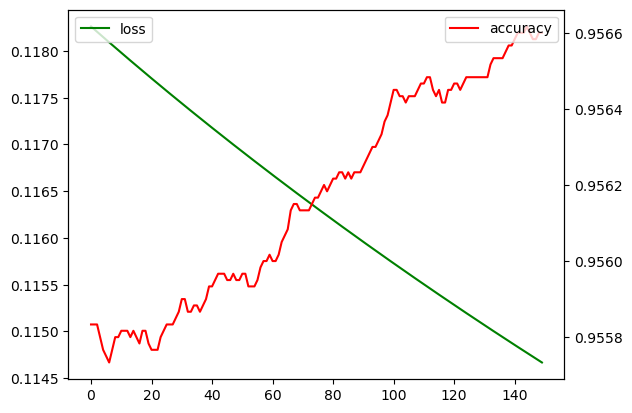

In [92]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()
ax1.plot(loss_accuracy[0], label='loss', color="g")

ax2 = ax1.twinx()
ax2.plot(loss_accuracy[1],label='accuracy', color='r')
# plt.plot(loss_accuracy[0], label='loss')
# plt.plot(loss_accuracy[1], label='accuracy')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.xlabel("Epochs")
plt.show()